# Long Short Term Memory

In [51]:
# lstm model
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv 
from pandas import DataFrame
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
from sklearn.model_selection import StratifiedKFold

## Human Activity Recognition Using Smartphones Data Set
Discuss the data set ...

## Loading the Data

This is a complicated data set ... we have many functions to read it in ...

In [65]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y
 
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'data/')
    print("Training Features Shape: " + str(trainX.shape))
    print("Training Labels Shape: " + str(trainy.shape))
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'data/')
    print("Testing Features Shape: " + str(testX.shape))
    print("Testing Labels Shape: " + str(testy.shape))
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    #trainy = to_categorical(trainy)
    #testy = to_categorical(testy)
    return trainX, trainy, testX, testy

Use the model to load the training and testing data sets

In [71]:
trainX, trainy, testX, testy = load_dataset()
# Creates One Hot Encodings (OHE) for the training data
trainY_OHE = to_categorical(trainy)
testY_OHE = to_categorical(testy)

Training Features Shape: (7352, 128, 9)
Training Labels Shape: (7352, 1)
Testing Features Shape: (2947, 128, 9)
Testing Labels Shape: (2947, 1)


## Investigate the Data

### Class Balance
As we have seen, it is important to understand the class balance of a data set. In the case of a HAR classification problem, we are interested in knowing how many examples of each type of activity we have in the data set. In the following cell, we explore this.

In [78]:
# convert the numpy array into a dataframe
df = DataFrame(trainy) 
# group data by the class value and calculate the number of rows
counts = df.groupby(0).size()
# retrieve raw rows
counts = counts.values
# summarize
print('Training Data Set:')
for i in range(len(counts)):
    percent = counts[i] / len(df) * 100
    print('Class=%d, total=%d, percentage=%.3f' % (i+1, counts[i], percent))

Training Data Set:
Class=1, total=1226, percentage=16.676
Class=2, total=1073, percentage=14.595
Class=3, total=986, percentage=13.411
Class=4, total=1286, percentage=17.492
Class=5, total=1374, percentage=18.689
Class=6, total=1407, percentage=19.138


### Ploting a Single Activity
Since we have time serise data, an important check is plotting all of the data in time. We can do this for a signle subject at a time to get a sense of what the signals may look like. The function below loads all of the data for a single example in the data set.

In [79]:
# get all data for one subject
def data_for_subject(X, y, sub_map, sub_id):
    # get row indexes for the subject id
    ix = [i for i in range(len(sub_map)) if sub_map[i]==sub_id]
    # return the selected samples
    return X[ix, :, :], y[ix]

For this data set, we know there is 50% overlap between each window in time, so it will not generate clean plots. The function below removes the window overlap for us.

In [80]:
# convert a series of windows to a 1D list
def to_series(windows):
    series = list()
    for window in windows:
        # remove the overlap from the window
        half = int(len(window) / 2) - 1
        for value in window[-half:]:
            series.append(value)
    return series

The following function is used to generate the plots we are interested in.

In [81]:
# plot the data for one subject
def plot_subject(X, y):
    pyplot.figure()
    # determine the total number of plots
    n, off = X.shape[2] + 1, 0
    # plot total acc
    for i in range(3):
        pyplot.subplot(n, 1, off+1)
        pyplot.plot(to_series(X[:, :, off]))
        pyplot.title('total acc '+str(i), y=0, loc='left')
        off += 1
    # plot body acc
    for i in range(3):
        pyplot.subplot(n, 1, off+1)
        pyplot.plot(to_series(X[:, :, off]))
        pyplot.title('body acc '+str(i), y=0, loc='left')
        off += 1
    # plot body gyro
    for i in range(3):
        pyplot.subplot(n, 1, off+1)
        pyplot.plot(to_series(X[:, :, off]))
        pyplot.title('body gyro '+str(i), y=0, loc='left')
        off += 1
    # plot activities
    pyplot.subplot(n, 1, n)
    pyplot.plot(y)
    pyplot.title('activity', y=0, loc='left')
    pyplot.show()

[ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]
(347, 128, 9) (347, 1)


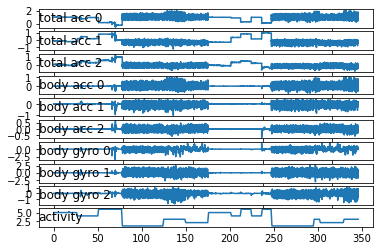

In [88]:
# load data
trainX, trainy = load_dataset_group('train', 'data/')
#trainX, trainy = load_dataset('train', 'data/')
# load mapping of rows to subjects
sub_map = load_file('data/train/subject_train.txt')
train_subjects = unique(sub_map)
print(train_subjects)
# get the data for one subject
sub_id = train_subjects[0]
subX, suby = data_for_subject(trainX, trainy, sub_map, sub_id)
print(subX.shape, suby.shape)
# plot data for subject
plot_subject(subX, suby)

## Making a Model

In [61]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

In [62]:
# Keep tihs line
model = Sequential()
# The dimensions here are important
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))

# Have them modify the inner ones

model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
# The dimensions here are important
model.add(Dense(n_outputs, activation='softmax'))
# Keep this line
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Evaluate the Model

In [ ]:
repeats = 2
scores = list()
for r in range(repeats):
    score = evaluate_model(trainX, trainY_OHE, testX, testY_OHE, model)
    score = score * 100.0
    print('>#%d: %.3f' % (r+1, score))
    scores.append(score)
# summarize results
summarize_results(scores)

In [30]:
def n_fold_cross_validation(X, y, k, model):
    fold = 0
    # This is a function that we will use to split the data into training and validation sets
    skf = StratifiedKFold(n_splits=k)
    for train_indices, test_indices in skf.split(X,y):
        # Get the training and validation data
        X_train, X_test = X[train_indices], X[test_indices]
        Y_train, Y_test = y[train_indices], y[test_indices]
        # Train the model on the training data
        model.fit(X_train, Y_train, epochs = 2, batch_size=64, verbose=0)
        # Get the predictions from the validation data 
        _, accuracy = model.evaluate(testX, testy, batch_size=64, verbose=0)
        print(accuracy)

In [33]:
n_fold_cross_validation(testX, testy, 5, model)

ValueError: Supported target types are: ('binary', 'multiclass'). Got 'multilabel-indicator' instead.

In [73]:
repeats = 2
scores = list()
for r in range(repeats):
    score = evaluate_model(trainX, trainY_OHE, testX, testY_OHE, model)
    score = score * 100.0
    print('>#%d: %.3f' % (r+1, score))
    scores.append(score)
# summarize results
summarize_results(scores)

>#1: 88.056
>#2: 90.092
[88.05565237998962, 90.09161591529846]
Accuracy: 89.074% (+/-1.018)


In [34]:
def evaluate_model(trainX, trainy, testX, testy, model):
    verbose, epochs, batch_size = 0, 2, 64
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy

In [12]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, model):
    verbose, epochs, batch_size = 0, 2, 64
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy
 
# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
 
# run an experiment
def run_experiment(repeats=2):
    # load data
    trainX, trainy, testX, testy = load_dataset()
    # repeat experiment
    scores = list()
    for r in range(repeats):
        score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)
 
# run the experiment
run_experiment()

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
>#1: 65.422
>#2: 71.395
[65.42246341705322, 71.39464020729065]
Accuracy: 68.409% (+/-2.986)


<ipython-input-49-dfcfece9111e>:75: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = pyplot.subplot(len(activity_ids), 1, k+1, sharex=xaxis)


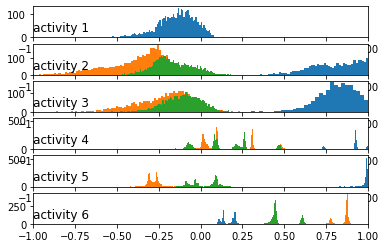

In [49]:
# plot histograms per activity for a subject
from numpy import array
from numpy import dstack
from numpy import unique
from pandas import read_csv
from matplotlib import pyplot
 
# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values
 
# load a list of files, such as x, y, z data for a given variable
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y
 
# get all data for one subject
def data_for_subject(X, y, sub_map, sub_id):
	# get row indexes for the subject id
	ix = [i for i in range(len(sub_map)) if sub_map[i]==sub_id]
	# return the selected samples
	return X[ix, :, :], y[ix]
 
# convert a series of windows to a 1D list
def to_series(windows):
	series = list()
	for window in windows:
		# remove the overlap from the window
		half = int(len(window) / 2) - 1
		for value in window[-half:]:
			series.append(value)
	return series
 
# group data by activity
def data_by_activity(X, y, activities):
	# group windows by activity
	return {a:X[y[:,0]==a, :, :] for a in activities}
 
# plot histograms for each activity for a subject
def plot_activity_histograms(X, y):
	# get a list of unique activities for the subject
	activity_ids = unique(y[:,0])
	# group windows by activity
	grouped = data_by_activity(X, y, activity_ids)
	# plot per activity, histograms for each axis
	pyplot.figure()
	xaxis = None
	for k in range(len(activity_ids)):
		act_id = activity_ids[k]
		# total acceleration
		for i in range(3):
			ax = pyplot.subplot(len(activity_ids), 1, k+1, sharex=xaxis)
			ax.set_xlim(-1,1)
			if k == 0:
				xaxis = ax
			pyplot.hist(to_series(grouped[act_id][:,:,i]), bins=100)
			pyplot.title('activity '+str(act_id), y=0, loc='left')
	pyplot.show()
 
# load data
trainX, trainy = load_dataset('train', 'data/')
# load mapping of rows to subjects
sub_map = load_file('data/train/subject_train.txt')
train_subjects = unique(sub_map)
# get the data for one subject
sub_id = train_subjects[0]
subX, suby = data_for_subject(trainX, trainy, sub_map, sub_id)
# plot data for subject
plot_activity_histograms(subX, suby)